<a href="https://colab.research.google.com/github/MohammedShabry/DL-Assignment/blob/malith/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DL assignment/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop unnecessary columns
df = df.drop(columns=['customerID'])

# Handle missing values in 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Convert categorical features into numeric using Label Encoding
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Select input features and target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Normalize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [5]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Reshape data for RNN
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define RNN model with improvements
rnn_model = Sequential()

# Add SimpleRNN layer with L2 regularization and dropout to prevent overfitting
rnn_model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train_reshaped.shape[1], 1),
                        kernel_regularizer=l2(0.001)))  # L2 regularization
rnn_model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Add Dense layer with L2 regularization and dropout
rnn_model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
rnn_model.add(Dropout(0.5))  # Dropout layer

# Output layer
rnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with custom learning rate
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overtraining
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
rnn_history = rnn_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2,
                            callbacks=[early_stopping])

# Evaluate on the test set
rnn_score = rnn_model.evaluate(X_test_reshaped, y_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7153 - loss: 0.6140 - val_accuracy: 0.7968 - val_loss: 0.4689
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7608 - loss: 0.5307 - val_accuracy: 0.7870 - val_loss: 0.4548
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7611 - loss: 0.4995 - val_accuracy: 0.7906 - val_loss: 0.4521
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7645 - loss: 0.4903 - val_accuracy: 0.7986 - val_loss: 0.4407
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7667 - loss: 0.4987 - val_accuracy: 0.7915 - val_loss: 0.4423
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7626 - loss: 0.4957 - val_accuracy: 0.8066 - val_loss: 0.4386
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7725 - loss: 0.4785 - val_accuracy: 0.8057 - val_loss: 0.4390
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7824 - loss: 0.4651 - val_

In [7]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions for the RNN model on the test set
rnn_preds = rnn_model.predict(X_test_reshaped)

# Binarize the predictions (convert probabilities to binary outcomes)
rnn_preds = (rnn_preds > 0.5).astype(int)

# Print classification report
print("RNN Model Classification Report")
print(classification_report(y_test, rnn_preds))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RNN Model Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



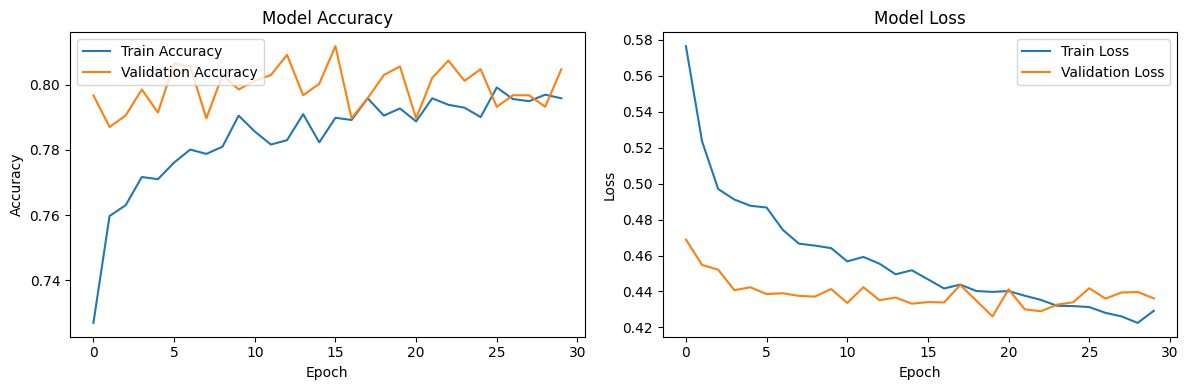

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()
